## MCMC application: Linear regression problems

### Example 1: Iris dataset

In [1]:
%matplotlib inline
import pymc3 as mc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
plt.rcParams["axes.unicode_minus"] = False

#### 1. Frequentist's approach: using the statsmodels library

Ref 1: http://www.statsmodels.org/devel/datasets/index.html

Ref 2: https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/00Index.html

In [2]:
dataset = sm.datasets.get_rdataset("iris")

In [3]:
data = dataset.data[dataset.data.Species == "setosa"]
data.head(10)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


**[Note] Pasty formula: smf.ols("y ~ x", data)**

For special strings: see $\underline{\text{patsy.builtins.Q(name)}}$

Ref: https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q

In [4]:
model = smf.ols("Q('Sepal.Width') ~ Q('Sepal.Length')", data)

result = model.fit()
result.params

Intercept           -0.569433
Q('Sepal.Length')    0.798528
dtype: float64

In [5]:
x = np.linspace(4, 6, 25)
y = result.predict({"Sepal.Length": x})

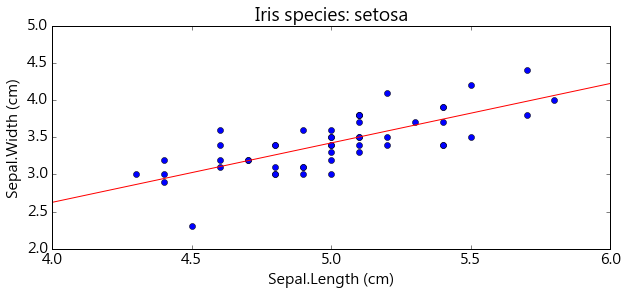

In [6]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(data["Sepal.Length"], data["Sepal.Width"], 'o')
ax.plot(x, y, color = 'red')
ax.set_xlabel("Sepal.Length (cm)", fontsize = 15)
ax.set_ylabel("Sepal.Width (cm)", fontsize = 15)
ax.set_title("Iris species: setosa", fontsize = 18)
ax.set_xlim(4, 6)
ax.set_ylim(2, 5)
ax.tick_params(axis = 'both', labelsize = 15)

#### 2. Bayesian approach: using MCMC with PyMC library

- PyMC3: https://docs.pymc.io/

In [8]:
with mc.Model() as model:
    intercept = mc.Normal('intercept', 0, sd = 3)
    beta = mc.Normal('beta', 1, sd = 3)
    sigma = mc.Uniform('sigma', 0.1, 1)
    
    width_mu = intercept + beta * data["Sepal.Length"]
    
    Width = mc.Normal('Width', mu = width_mu, sd = sigma, observed = data["Sepal.Width"])

    # For prediction
    predict_width = mc.Normal('predict_width', mu = intercept + beta * x, sd = sigma, shape = len(x))
    
# show the model variables
model.vars

[intercept, beta, sigma_interval__, predict_width]

In [9]:
with model:
    start = mc.find_MAP()
    step = mc.NUTS()
    trace = mc.sample(10000, start = start, step = step, cores = 2)

logp = 8.4027, ||grad|| = 2.3593: 100%|████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.30it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [predict_width, sigma_interval__, beta, intercept]
Could not pickle model, sampling singlethreaded.
Sequential sampling (2 chains in 1 job)
NUTS: [predict_width, sigma_interval__, beta, intercept]
100%|██████████████████████████████████████████████████████████████████████████████| 10500/10500 [02:19<00:00, 75.52it/s]


In [15]:
print("len(trace) = ", len(trace))
print("trace.nchains = ", trace.nchains)
print("trace['intercept'].shape = ", trace['intercept'].shape)

len(trace) =  10000
trace.nchains =  2
trace['intercept'].shape =  (20000,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010B41438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000E4D54E0>]], dtype=object)

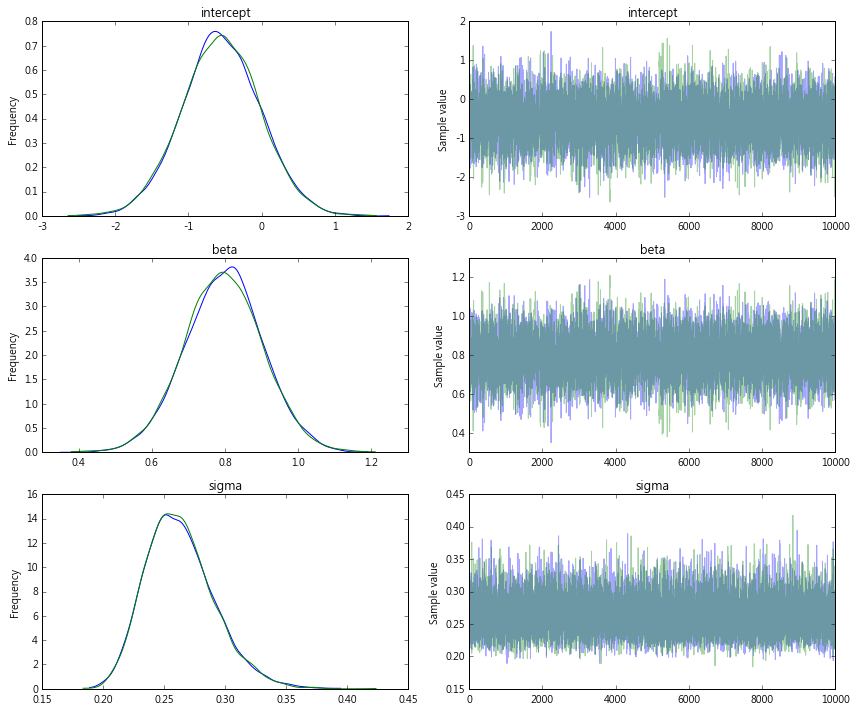

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10), squeeze = False)
mc.traceplot(trace, ['intercept', 'beta', 'sigma'], ax = axes)

In [17]:
print("intercept(MCMC) = ", trace.get_values('intercept', chains = 1).mean())
print("beta(MCMC) = ", trace.get_values('beta', chains = 1).mean())
print("sigma = ", trace.get_values('sigma', chains = 1).mean())
print("---------------------------------------------------------------")

print("intercept(OLS) = ", result.params[0])
print("beta(OLS) = ", result.params[1])

intercept(MCMC) =  -0.554782220224
beta(MCMC) =  0.795558720818
sigma =  0.263476872654
---------------------------------------------------------------
intercept(OLS) =  -0.56943267304
beta(OLS) =  0.798528300647


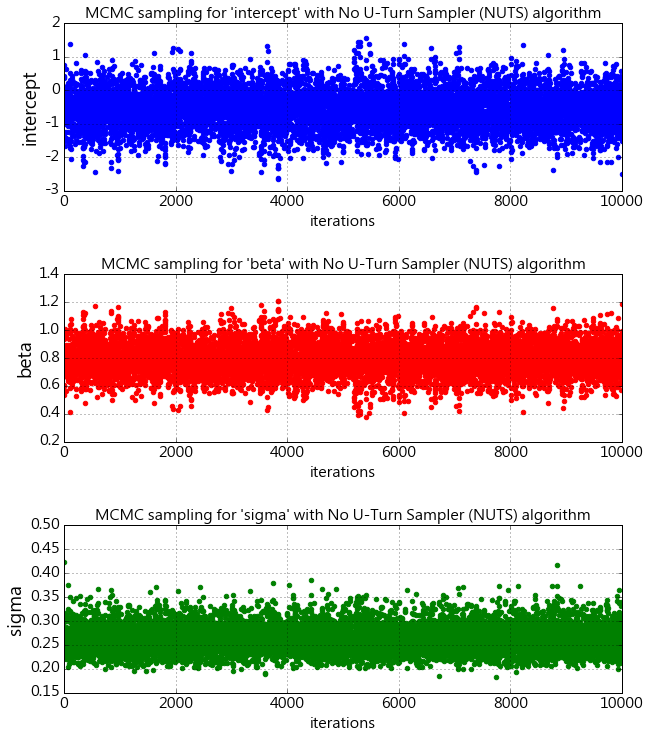

In [18]:
var = np.array(['intercept', 'beta', 'sigma'])
col = ['blue', 'red', 'green']

fig, ax = plt.subplots(var.size, 1, figsize = (10, 12))
plt.subplots_adjust(hspace = 0.5)
for i in range(var.size):
    ax[i].tick_params(axis = 'both', labelsize = 15)
    ax[i].scatter(np.arange(trace.get_values(var[i], chains = 1).size), trace.get_values(var[i], chains = 1)[:], color = col[i])
    ax[i].set_xlabel("iterations", fontsize = 15)
    ax[i].set_ylabel(var[i], fontsize = 18)
    ax[i].set_title("MCMC sampling for '" + str(var[i]) + "' with No U-Turn Sampler (NUTS) algorithm", fontsize = 15)
    ax[i].set_xlim(0, trace.get_values(var[i], chains = 1).size)
    ax[i].grid()

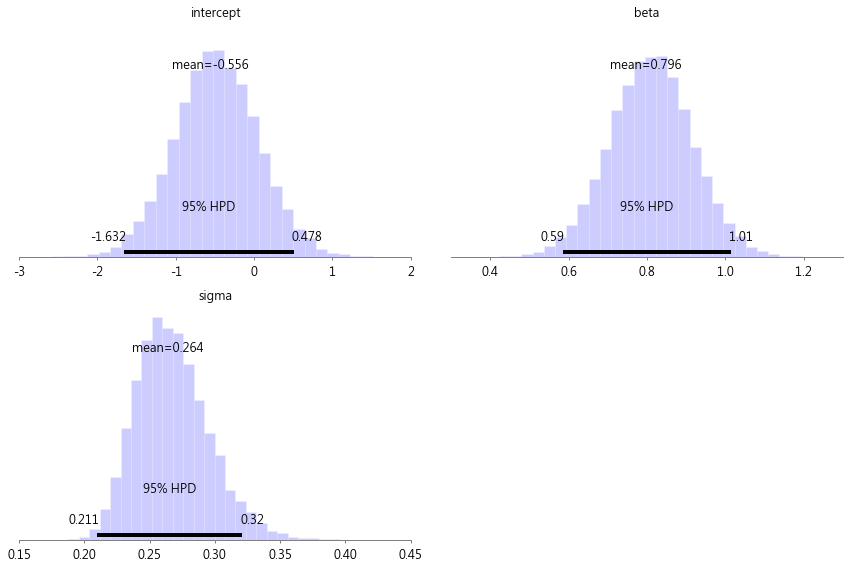

In [19]:
mc.plot_posterior(trace, ['intercept', 'beta', 'sigma'], figsize = (12, 8), alpha = 0.2);

#### 3. Sepal width prediction for a given setosa's sepal length

(1) Prediction from OLS

In [20]:
OLS = result.predict({"Sepal.Length": 5.75})[0]
OLS

4.0221050556814788

(2) Prediction from MCMC

In [21]:
trace.get_values("predict_width").shape

(20000, 25)

In [22]:
width_index = np.where(x == 5.75)
trace.get_values("predict_width")[:, width_index].mean()

4.0223078107662129

(3) Comparison

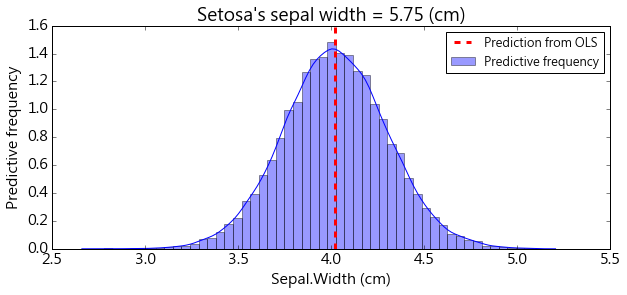

In [23]:
fig, ax = plt.subplots(figsize = (10, 4))
sns.distplot(trace.get_values("predict_width")[:, width_index], label = 'Predictive frequency', ax = ax)
ax.set_xlabel("Sepal.Width (cm)", fontsize = 15)
ax.set_ylabel("Predictive frequency", fontsize = 15)
ax.set_title("Setosa's sepal width = 5.75 (cm)", fontsize = 18)
ax.tick_params(axis = 'both', labelsize = 15)
ax.axvline(OLS, ls = '--', lw = 3, color = 'r', label = 'Prediction from OLS')
ax.legend();

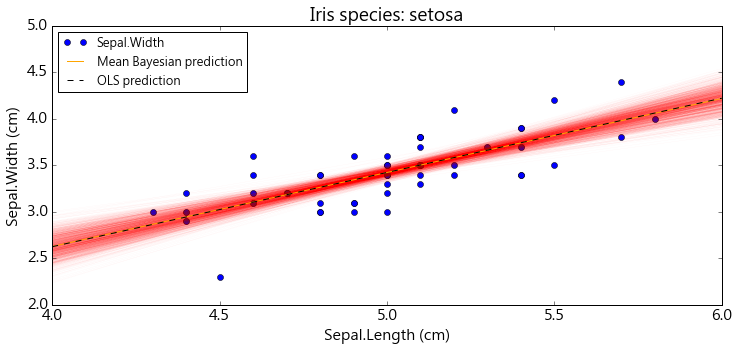

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(data["Sepal.Length"], data["Sepal.Width"], 'o')

for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta = trace.get_values("beta")[n]
    ax.plot(x, intercept + beta * x, color = 'red', lw = 0.25, alpha = 0.05)

intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()
ax.plot(x, intercept + beta * x, color = 'orange', label = "Mean Bayesian prediction")

ax.plot(x, y, color = 'k', ls = '--', label = "OLS prediction")

ax.set_xlabel("Sepal.Length (cm)", fontsize = 15)
ax.set_ylabel("Sepal.Width (cm)", fontsize = 15)
ax.set_title("Iris species: setosa", fontsize = 18)
ax.set_xlim(4, 6)
ax.set_ylim(2, 5)
ax.tick_params(axis = 'both', labelsize = 15)
ax.legend(loc = 0)

### Example 2: Supernovae Ia

In [ ]:
M_max = [-17.3, -15.5, -15.6, -12.0, -10.1]